# **Bumble Exploratory Data Analysis Report**

## Introduction:
Bumble is a popular dating platform where users connect based on mutual interests and compatibility. To provide a better matchmaking experience, Bumble collects user information through profiles, which include details about demographics, lifestyle habits, and personal preferences.
Our task is to conduct a detailed exploratory analysis of Bumble dataset to answer key business and user behavior questions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("bumble.csv") #Reading data

## Dataset Details

### 1. Demographics
- ***age:*** Age of the user.
- ***status:*** Relationship status (e.g., single, married, seeing someone).
- ***gender:*** Gender of the user (e.g., m, f).

### 2. Physical Attributes
- ***body_type:*** Descriptions of physical appearance (e.g., athletic, curvy, thin).
- ***height:*** Height of the user (in inches).

### 3. Lifestyle Preferences
- ***diet:*** Dietary preferences (e.g., vegetarian, vegan, anything).
- ***drinks:*** Drinking habits (e.g., socially, often).

### 4. Educational and Financial Details
- ***education:*** Education level (e.g., college, masters).
- ***income:*** User-reported annual income.

### 5. Location and Activity
- ***location:*** City and state where the user resides.
- ***last_online:*** Date and time when the user was last active.

# Part 1 : Data Cleaning

## 1. Inspecting Missing Data
Missing data is a common issue in real-world datasets. On a platform like Bumble, missing user information may occur due to incomplete profile setup, gaps in data collection, or users intentionally skipping certain fields. As a data analyst, we need to evaluate how much data is missing, understand its impact on my analysis, and decide the most suitable strategy to handle it.

### Question 1.1: Which columns in the dataset have missing values, and what percentage of data is missing in each column?

In [3]:
missing_value_columns = data.isnull().sum()
print("Missing Value Columns:\n", missing_value_columns,)

Missing Value Columns:
 age                0
status             0
gender             0
body_type       5296
diet           24395
drinks          2985
education       6628
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
pets           19921
religion       20226
sign           11056
speaks            50
dtype: int64


**1.1 Which columns in the dataset have missing values, and what percentage of data is missing in each column?**

In [4]:
missing_count = data.isnull().sum()
missing_percentage = (missing_count / len(data)) * 100
print("Missing value percentage:\n", missing_percentage)

Missing value percentage:
 age             0.000000
status          0.000000
gender          0.000000
body_type       8.834618
diet           40.694959
drinks          4.979482
education      11.056618
ethnicity       9.475194
height          0.005005
income          0.000000
job            13.675641
last_online     0.000000
location        0.000000
pets           33.231575
religion       33.740366
sign           18.443266
speaks          0.083408
dtype: float64


**1.2)Are there columns where more than 50% of the data is missing? Drop those columns where missing values are >50%.**

In [5]:
#columns with >50% missing values
cols_to_drop = missing_percentage[missing_percentage > 50].index


if len(cols_to_drop) > 0:
    print("Columns with >50% missing values and will be dropped:", cols_to_drop.tolist())
    data = data.drop(columns=cols_to_drop)
else:
    #if no column has missing
    print("✅ No columns with >50% missing values. No columns dropped.")

✅ No columns with >50% missing values. No columns dropped.


**1.3) Missing numerical data (e.g., height, income) should be handled by imputing the median value of height and income for the corresponding category, such as gender, age group, or location. This ensures that the imputed values are contextually relevant and reduce potential biases in the analysis.**

In [6]:
# Impute height & income by median grouped by gender
data['height'] = data.groupby('gender')['height'].transform(
    lambda x: x.fillna(x.median())
)

data['income'] = data.groupby('age')['income'].transform(
    lambda x: x.fillna(x.median())
)

#verify
print(data[['height','income']].isnull().sum())

height    0
income    0
dtype: int64


**Important findings and conclusions:**
- diet(40.69%), pets(33.23%), religion(33.74%), sign(18.44%) have maximum missing values.
- No columns with >50% missing values
- height and income missing data are imputed based on median value based on gender and age respectively

## 2: Data Types
Accurate data types are critical for meaningful analysis and visualization. For example, numeric fields like income or height must be stored as numbers for statistical computations, while dates like last_online must be converted to datetime format for time-based calculations.

In [7]:
data.dtypes

age              int64
status          object
gender          object
body_type       object
diet            object
drinks          object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
pets            object
religion        object
sign            object
speaks          object
dtype: object

**2.1) Are there any inconsistencies in the data types across columns (e.g., numerical data stored as strings)?**

- Columns with numeric data types like age, height and income do not have inconsistency
- last_online column is inconsistent as it is given as object type but it should be date_time format

**2.2) Which columns require conversion to numerical data types for proper analysis**


All the numeric columns are correct and none require to be converted

**Question 2.3: Does the last_online column need to be converted into a datetime format? What additional insights can be gained by analyzing this as a date field?**


In [8]:
data['last_online'] = pd.to_datetime(data['last_online'], format = '%Y-%m-%d-%H-%M')
#Verify
data['last_online'].dtype

dtype('<M8[ns]')

last online was initially a string now converted to datetime

## Part 3: Outliers
Outliers are extreme values in the dataset that can distort averages, correlations, and overall trends. In the context of Bumble, an outlier in age (e.g., 110 years old) or income (e.g., $1,000,000 or -1) could represent errors or rare, valid cases.

In [9]:
#Defining outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.10)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column]
    return outliers, lower_bound, upper_bound



**3.1)Are there any apparent outliers in numerical columns such as age, height, or income? What are the ranges of values in these columns?**

In [10]:
for col in ['age', 'height', 'income']:
    outliers, l, u = detect_outliers_iqr(data, col)
    min_value = data[col].min()
    max_value = data[col].max()

    print(f" {col}")
    print(f"Range: {min_value} → {max_value}")
    print(f"Lower Bound: {l:.2f}, Upper Bound: {u:.2f}")
    print(f"Total Outliers: {len(outliers)}")
    print("Outliers:", outliers.tolist())

 age
Range: 18 → 110
Lower Bound: -11.50, Upper Bound: 80.50
Total Outliers: 2
Outliers: [110, 109]
 height
Range: 1.0 → 95.0
Lower Bound: 48.00, Upper Bound: 88.00
Total Outliers: 54
Outliers: [91.0, 95.0, 95.0, 36.0, 43.0, 95.0, 93.0, 8.0, 36.0, 95.0, 36.0, 3.0, 36.0, 42.0, 95.0, 36.0, 94.0, 6.0, 95.0, 47.0, 91.0, 36.0, 36.0, 95.0, 95.0, 95.0, 95.0, 94.0, 90.0, 37.0, 9.0, 95.0, 95.0, 95.0, 37.0, 91.0, 36.0, 1.0, 43.0, 92.0, 36.0, 26.0, 95.0, 95.0, 95.0, 95.0, 89.0, 95.0, 36.0, 4.0, 95.0, 36.0, 95.0, 94.0]
 income
Range: -1 → 1000000
Lower Bound: -75002.50, Upper Bound: 125001.50
Total Outliers: 1349
Outliers: [1000000, 150000, 1000000, 500000, 1000000, 150000, 150000, 250000, 150000, 150000, 1000000, 1000000, 150000, 150000, 150000, 250000, 150000, 250000, 500000, 1000000, 150000, 150000, 150000, 1000000, 1000000, 150000, 150000, 150000, 1000000, 250000, 150000, 150000, 250000, 150000, 250000, 1000000, 1000000, 1000000, 250000, 150000, 1000000, 1000000, 150000, 150000, 1000000, 25000

**3.2)Any -1 values in numerical columns like income should be replaced with 0, as they may represent missing or invalid data.**

In [11]:
data['income'] = data['income'].replace(-1, 0)

**3.3)For other outliers, rather than deleting them, calculate the mean and median values using only the middle 80% of the data (removing extreme high and low values). This approach ensures that outliers do not disproportionately impact the analysis while retaining as much meaningful data as possible.**

In [12]:
import pandas as pd

def trimmed_stats(series, lower_q=0.10, upper_q=0.90):
    """Return mean & median using only values between the given quantiles."""
    lo = series.quantile(lower_q)
    hi = series.quantile(upper_q)
    trimmed = series[(series >= lo) & (series <= hi)]
    return {
        "lower_q": lo,
        "upper_q": hi,
        "mean_trim80": trimmed.mean(),
        "median_trim80": trimmed.median(),
        "n_used": trimmed.size,
        "n_total": series.size
    }

numeric_cols = data.select_dtypes(include=['int64','float64']).columns

summary = {}
for col in numeric_cols:
    stats = trimmed_stats(data[col])
    summary[col] = stats
    print(f"\n{col}")
    print(f"10th–90th bounds: {stats['lower_q']:.3f} – {stats['upper_q']:.3f}")
    print(f"Mean (middle 80%):   {stats['mean_trim80']:.3f}")
    print(f"Median (middle 80%): {stats['median_trim80']:.3f}")
    print(f"Used {stats['n_used']} of {stats['n_total']} rows")


age
10th–90th bounds: 23.000 – 46.000
Mean (middle 80%):   31.090
Median (middle 80%): 30.000
Used 49367 of 59946 rows

height
10th–90th bounds: 63.000 – 73.000
Mean (middle 80%):   68.231
Median (middle 80%): 68.000
Used 50200 of 59946 rows

income
10th–90th bounds: 0.000 – 50000.000
Mean (middle 80%):   3297.012
Median (middle 80%): 0.000
Used 54422 of 59946 rows


## 4: Missing Data Visualization:
Visualizing missing data helps identify patterns of incompleteness in the dataset, which can guide data cleaning strategies. Understanding which columns have high levels of missing data ensures decisions about imputation or removal are well-informed.

**Questions 4.1:** Create a heatmap to visualize missing values across the dataset. Which columns show consistent missing data patterns?

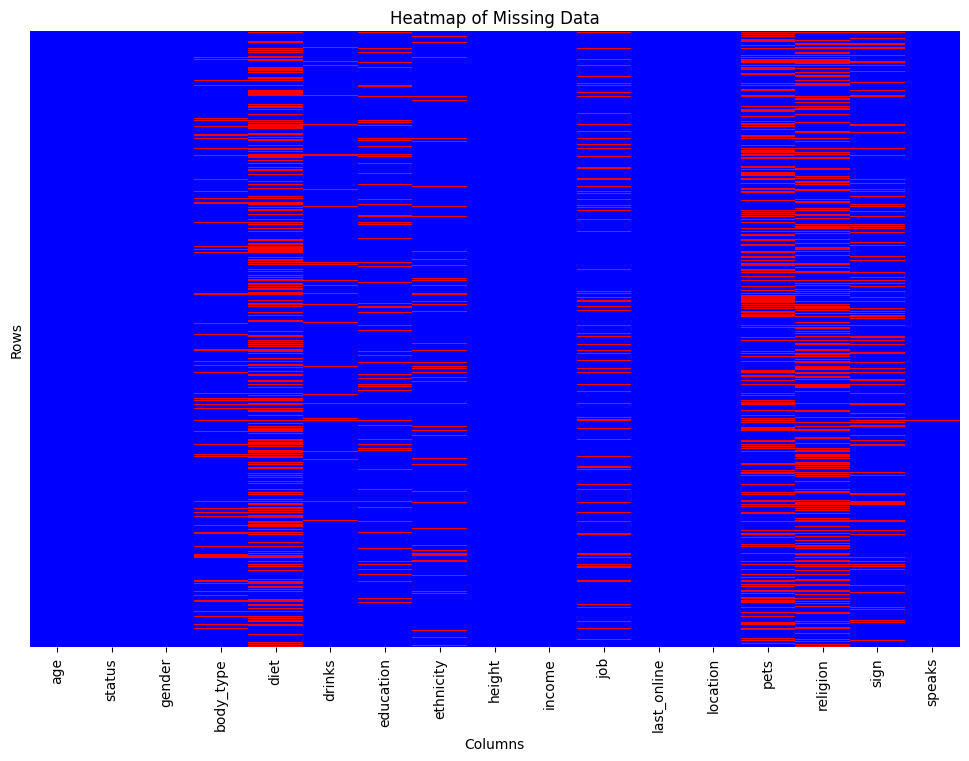

In [13]:
missing_data = data.isna()

# Plotting a heatmap to visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cbar=False, cmap="bwr", yticklabels=False)
plt.title("Heatmap of Missing Data")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# Part 2 : Data Processing
## 1.Binning and Grouping
Grouping continuous variables, such as age or income, into bins helps simplify analysis and identify trends among specific groups. For instance, grouping users into age ranges can reveal distinct patterns in behavior or preferences across demographics.

**Questions 1.1:Bin the age column into categories such as "18-25", "26-35", "36-45", and "46+" to create a new column, age_group. How does the distribution of users vary across these age ranges?**

In [14]:
bins = [18, 25, 35, 45, float('inf')]
labels = ["18-25", "26-35", "36-45", "46+"]
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# Analyzing the distribution of users across age groups
age_group_distribution = data['age_group'].value_counts().sort_index()
print("Distribution of users across age ranges:", age_group_distribution)

Distribution of users across age ranges: age_group
18-25    14145
26-35    28621
36-45    10803
46+       6068
Name: count, dtype: int64


*Conclusion* : Age group 26-35 have maximum number of users followed by age group 18-25.

**Question 1.2: Group income into categories like "Low Income," "Medium Income," and "High Income" based on meaningful thresholds (e.g., quartiles). What insights can be derived from these groups?Group income into categories like "Low Income," "Medium Income," and "High Income" based on meaningful thresholds (e.g., quartiles). What insights can be derived from these groups?**

In [15]:
# calculating thresholds based on quartiles
low_threshold = data['income'].quantile(0.10)
medium_threshold = data['income'].quantile(0.90)

# defining function to categorize income nad applying the function on 'income' column
def categorize_income(income):
    if income <= low_threshold:
        return "Low Income"
    elif income <= medium_threshold:
        return "Medium Income"
    else:
        return "High Income"
data['income_group'] = data['income'].apply(categorize_income)

# Analyzing the distribution of income groups
income_group_distribution = data['income_group'].value_counts()
print("Income Group Distribution:", income_group_distribution)

Income Group Distribution: income_group
Low Income       48442
Medium Income     5980
High Income       5524
Name: count, dtype: int64


*Conclusion: Maximum number of users have low income. High income users are very less.*

## 2. Derived Features
Derived features are new columns created based on the existing data to add depth to the analysis. These features often reveal hidden patterns or provide new dimensions to explore.

**Questions 2.1: Create a new feature, profile_completeness, by calculating the percentage of non-missing values for each user profile. How complete are most user profiles, and how does completeness vary across demographics?**

# Creating a new feature: 'percentage of non-missing values' for each user and analyzing the distribution of profile completeness
data['profile_completeness'] = data.notnull().sum(axis=1) / data.shape[1] * 100
print("Profile Completeness Percentage:\n", data['profile_completeness'].round(2).head())

# Grouping by gender to analyze variation in completeness
completeness_by_gender = data.groupby('gender')['profile_completeness'].mean().round(2)
print("\nAverage Profile Completeness by Gender:\n", completeness_by_gender)

*Conclusion:Female have more profile completeness than males.*

In [16]:
# Creating a new feature: 'percentage of non-missing values' for each user and analyzing the distribution of profile completeness
data['profile_completeness'] = data.notnull().sum(axis=1) / data.shape[1] * 100
print("Profile Completeness Percentage:\n", data['profile_completeness'].round(2).head())

# Grouping by gender to analyze variation in completeness
completeness_by_gender = data.groupby('gender')['profile_completeness'].mean().round(2)
print("\nAverage Profile Completeness by Gender:\n", completeness_by_gender)

Profile Completeness Percentage:
 0    100.00
1    100.00
2     84.21
3     94.74
4     89.47
Name: profile_completeness, dtype: float64

Average Profile Completeness by Gender:
 gender
f    91.00
m    90.67
Name: profile_completeness, dtype: float64


*Conclusion:Female have more profile completeness than males.*


## 3. Unit Conversion

Standardizing units across datasets is essential for consistency, especially when working with numerical data. In the context of the Bumble dataset, users’ heights are given in inches, which may not be intuitive for all audiences.

**Questions 3.1: Convert the height column from inches to centimeters using the conversion factor (1 inch = 2.54 cm). Store the converted values in a new column, height_cm.**

In [17]:
# Creating a new column with height in centimeters ( formula: 1 inch = 2.54 cm)
conversion_factor = 2.54
data['height_cm'] = data['height'] * conversion_factor
# Verifying if new column added
data[['height', 'height_cm']].head()

,height,height_cm
0,75.0,190.50
1,70.0,177.80
2,68.0,172.72
3,71.0,180.34
4,66.0,167.64


# Part 3: Data Analysis

## 1. Demographic Analysis

Understanding the demographics of users is essential for tailoring marketing strategies, improving user experience, and designing features that resonate with the platform’s audience. Insights into gender distribution, orientation, and relationship status can help Bumble refine its matchmaking algorithms and engagement campaigns.

**Question 1.1: What is the gender distribution (gender) across the platform? Are there any significant imbalances?**

In [19]:
# calculating gender distribution
gender_distribution = data['gender'].value_counts()
print("Gender Distribution:\n", gender_distribution)

# checking for significant imbalances
total_users = gender_distribution.sum()
imbalance = gender_distribution / total_users * 100
print("\nPercentage Distribution:\n", imbalance.round(2))

Gender Distribution:
 gender
m    35829
f    24117
Name: count, dtype: int64

Percentage Distribution:
 gender
m    59.77
f    40.23
Name: count, dtype: float64


*Conclusion: The number of male users is more than females*

**Question 1.2:What are the proportions of users in different status categories (e.g., single, married, seeing someone)? What does this suggest about the platform’s target audience?**

In [20]:
#status value counts
status= data['status'].value_counts()

#calculating proportions
proportion = status/ status.sum() * 100

In [21]:
print("\n Status Preparation: \n", proportion.round(2))


 Status Preparation: 
 status
single            92.91
seeing someone     3.44
available          3.11
married            0.52
unknown            0.02
Name: count, dtype: float64


*Conclusion: Most of the users are single*

**Question 1.3: How does status vary by gender? For example, what proportion of men and women identify as single?**

In [22]:
status_gender = data.groupby('gender')['status'].value_counts(normalize=True)*100
print("Status Proportions by gender:\n", status_gender.round(2))

Status Proportions by gender:
 gender  status        
f       single            92.54
        seeing someone     4.16
        available          2.72
        married            0.56
        unknown            0.02
m       single            93.16
        available          3.37
        seeing someone     2.96
        married            0.49
        unknown            0.02
Name: proportion, dtype: float64


*Conclusion: Both men and women have more than 90% single. This suggests most people using the platform are single regardless of gender and are looking for fresh start and new connections. There is no significant gender based imbalances.*

## 2. Correlation Analysis: 
Correlation analysis helps uncover relationships between variables, guiding feature engineering and hypothesis generation. For example, understanding how age correlates with income or word count in profiles can reveal behavioral trends that inform platform design.

**Question 2.1:What are the correlations between numerical columns such as age, income, gender Are there any strong positive or negative relationships?**

In [23]:
income = data[data['income'] > 0]
nums = ['age', 'income', 'height']
correlation_matrix = income[nums].corr().round(4)
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
            age  income  height
age     1.0000 -0.0092 -0.0117
income -0.0092  1.0000  0.0588
height -0.0117  0.0588  1.0000


*Conclusion: Income and height are positively correlated with each other. Age is negatively correlated with height and income.*

**Question 2.2: How does age correlate with income? Are older users more likely to report higher income levels?**

In [24]:
age_inc_corr = data['age'].corr(data['income'])

In [27]:
print("Correlation between age and income:" ,age_inc_corr)
print("Conclusion:")
if age_inc_corr > 0:
    print("Positive")
else:
    print("Negative")

print("correlation between age and income")

Correlation between age and income: -0.0010038681910054124
Conclusion:
Negative
correlation between age and income


## 3. Diet and Lifestyle Analysis:
Lifestyle attributes such as diet, drinks provide insights into user habits and preferences. Analyzing these factors helps identify compatibility trends and inform product features like filters or match recommendations.

**Question 3.1: How do dietary preferences (diet) distribute across the platform? For example, what percentage of users identify as vegetarian, vegan, or follow "anything" diets?**

In [29]:
diet_preference = data['diet'].value_counts(normalize="True")*100
print("Dietary Prefernce Distribution: \n", diet_preference.round(2))

Dietary Prefernce Distribution: 
 diet
mostly anything        46.65
anything               17.39
strictly anything      14.38
mostly vegetarian       9.69
mostly other            2.83
strictly vegetarian     2.46
vegetarian              1.88
strictly other          1.27
mostly vegan            0.95
other                   0.93
strictly vegan          0.64
vegan                   0.38
mostly kosher           0.24
mostly halal            0.14
strictly halal          0.05
strictly kosher         0.05
halal                   0.03
kosher                  0.03
Name: proportion, dtype: float64


*Conclusion: Most of the users are open to any type of diet (~75%). Vegeterian is prefered by 10-15 % of users.*

**Question 3.2: How do drinking habits (drinks) vary across different diet categories? Are users with stricter diets (e.g., vegan) less likely to drink?**

In [30]:
drink_diet = data.groupby('diet')['drinks'].value_counts(normalize = True).unstack()*100
print("\nDrinking Habits by Diet (%):\n", drink_diet.round(2).to_string(float_format="{:.2f}".format))


Drinking Habits by Diet (%):
 drinks               desperately  not at all  often  rarely  socially  very often
diet                                                                             
anything                    0.35        4.92   9.58    8.51     75.67        0.97
halal                        NaN       44.44  11.11     NaN     44.44         NaN
kosher                       NaN        9.09    NaN   18.18     63.64        9.09
mostly anything             0.41        5.19   8.54    9.47     75.61        0.79
mostly halal                6.98       23.26   4.65   18.60     37.21        9.30
mostly kosher               1.19        8.33   4.76   20.24     59.52        5.95
mostly other                0.82        9.33   5.03   18.05     66.26        0.51
mostly vegan                0.62       12.42   6.83   19.25     59.94        0.93
mostly vegetarian           0.57        5.87   7.02   14.03     71.91        0.60
other                       0.32       11.22   7.37   19.23     61.

*Conclusion: Across almost all diet preferences have maximum number of user drinks socially. Even the users with strict diet preferences have maximum users that drinks socially. Strict Kosher diet tend to drink desperately*

## 4. Geographical Insights

Analyzing geographical data helps Bumble understand its user base distribution, enabling targeted regional campaigns and feature localization. For instance, identifying the top cities with active users can guide marketing efforts in those areas.

**Question 4.1: Extract city and state information from the location column. What are the top 5 cities and states with the highest number of users?**

In [31]:
# Spliting the 'location' column into 'city' and 'state' columns
location_split = data['location'].str.split(',', expand=True)
data['city'] = location_split[0].str.strip()
data['state'] = location_split[1].str.strip()

# Counting the top 5 cities with maximum number of users
top_cities = data['city'].value_counts().sort_values(ascending=False).head(5)
print("Top 5 Cities with the Highest Number of Users:\n", top_cities)

# Counting the top 5 states with maximum number of users
top_states = data['state'].value_counts().sort_values(ascending=False).head(5)
print("\nTop 5 States with the Highest Number of Users:\n", top_states)

Top 5 Cities with the Highest Number of Users:
 city
san francisco    31064
oakland           7214
berkeley          4212
san mateo         1331
palo alto         1064
Name: count, dtype: int64

Top 5 States with the Highest Number of Users:
 state
california       59855
new york            17
illinois             8
massachusetts        5
texas                4
Name: count, dtype: int64


*Conclusion: San Francisco has largest userbase by a wide margin. Oakland and Berkley also have many users. Carliforna has largest user base.*

**Question 4.2: How does age vary across the top cities? Are certain cities dominated by younger or older users?**

In [32]:
top_cities = data['city'].value_counts().head(5).index
top_cities_data = data[data['city'].isin(top_cities)]
avg_age_by_top_cities = top_cities_data.groupby('city')['age'].mean().sort_values(ascending=False)
print("Average Age Across Top Cities:\n", avg_age_by_top_cities.round(2))

Average Age Across Top Cities:
 city
san mateo        33.44
oakland          33.18
palo alto        31.98
san francisco    31.61
berkeley         31.39
Name: age, dtype: float64


*Cities with maximum users have almost same average age values. All cities are dominated by mid age users.*

**Question 4.3: What are the average income levels in the top states or cities? Are there regional patterns in reported income?**

In [33]:
top_states = data['state'].value_counts().head(5).index
top_cities = data['city'].value_counts().head(5).index

# calculating the average income for top states
avg_income_state = (data[data['state'].isin(top_states)].groupby('state')['income'].mean().round(2).sort_values(ascending=False))
print("Average Income in Top States:\n", avg_income_state)

#Calculating the average income for top cities
avg_income_cities = (data[data['city'].isin(top_cities)].groupby('city')['income'].mean().round(2).sort_values(ascending=False))
print("\nAverage Income in Top Cities:\n", avg_income_cities)

Average Income in Top States:
 state
new york         31764.71
california       20044.27
massachusetts     6000.00
texas             5000.00
illinois             0.00
Name: income, dtype: float64

Average Income in Top Cities:
 city
san mateo        22779.86
oakland          22586.64
san francisco    20150.01
palo alto        19332.71
berkeley         17364.67
Name: income, dtype: float64


*Conclusion: New York and San Francisco have maximum average income among states. San Mateo, Oakland and San Franciso have highest average income users among the states.*

## 5. Height Analysis
Physical attributes like height are often considered important in dating preferences. Analyzing height patterns helps Bumble understand user demographics and preferences better.

**Question 5.1: What is the average height of users across different gender categories?**

In [34]:
avg_height_gender = data.groupby('gender')['height_cm'].mean()
print("Average Height across different gender:", avg_height_gender.round(2))

Average Height across different gender: gender
f    165.36
m    178.93
Name: height_cm, dtype: float64


*Conclusion: The male average height is 178.93 cm and female average is 165,36 cm*

**Question 5.2: How does height vary by age_group? Are there noticeable trends among younger vs. older users?**

In [36]:
avg_height_age_group = data.groupby('age_group')['height_cm'].mean()
print("Average Height by Age Group:\n", avg_height_age_group.round(2))

Average Height by Age Group:
 age_group
18-25    173.29
26-35    173.75
36-45    173.55
46+      172.57
Name: height_cm, dtype: float64


/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/72371414.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_height_age_group = data.groupby('age_group')['height_cm'].mean()


*Conclusion:Users with age group 26-35 have maximum average height among the groups.*

**Question 5.3: What is the distribution of height within body_type categories (e.g., athletic, curvy, thin)? Do the distributions align with expectations?**

In [37]:
avg_height_body_type = data.groupby('body_type')['height_cm'].mean()
print("Average Height by Body Type:\n", avg_height_body_type.round(2))

Average Height by Body Type:
 body_type
a little extra    174.80
athletic          177.06
average           172.98
curvy             165.63
fit               174.11
full figured      168.82
jacked            176.00
overweight        175.13
rather not say    170.87
skinny            174.10
thin              172.38
used up           175.72
Name: height_cm, dtype: float64


*Conclusion: Users with Athletic build have more average height and curvy have least average height. Athletic build are expected to be taller due to better health and genetics while curvya and full body types are shorter and need more positivity.*

## 6. Income Analysis
Income is often an important factor for users on dating platforms. Understanding its distribution and relationship with other variables helps refine features like user search filters or personalized recommendations.

**Question 6.1: What is the distribution of income across the platform? Are there specific income brackets that dominate? (don't count 0)**

In [39]:
filtered_income = data[data['income'] > 0]
income_distribution = data.groupby('income_group')['income'].mean()
print("Average Income Across Plateform:\n", income_distribution.round(2))

Average Income Across Plateform:
 income_group
High Income      184925.78
Low Income            0.00
Medium Income     30005.02
Name: income, dtype: float64


*Conclusion: Most users belong to high income segment*

**Question 6.2: How does income vary by age_group and gender? Are older users more likely to report higher incomes?**

In [40]:
filtered_income = data[data['income'] > 0]
income_age_gender = filtered_income.groupby(['age_group', 'gender'])['income'].mean()
print("Income by Age Group and Gender:\n", income_age_gender.round(2))

Income by Age Group and Gender:
 age_group  gender
18-25      f          86964.50
           m         107654.80
26-35      f          90398.13
           m         114944.80
36-45      f          87302.98
           m         112680.61
46+        f          75299.76
           m         100156.63
Name: income, dtype: float64


/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/554149359.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_age_gender = filtered_income.groupby(['age_group', 'gender'])['income'].mean()


*Conclusion: In all groups the average income of male is more than females with the age group 26-35 being highest earning.*

# Part 4: Data Visualization

## 1. Age Distribution
Understanding the distribution of user ages can reveal whether the platform caters to specific demographics or age groups. This insight is essential for targeted marketing and user experience design.

**Question 1.1: Plot a histogram of age with a vertical line indicating the mean age. What does the distribution reveal about the most common age group on the platform?**


Mean Age is:
 32.34


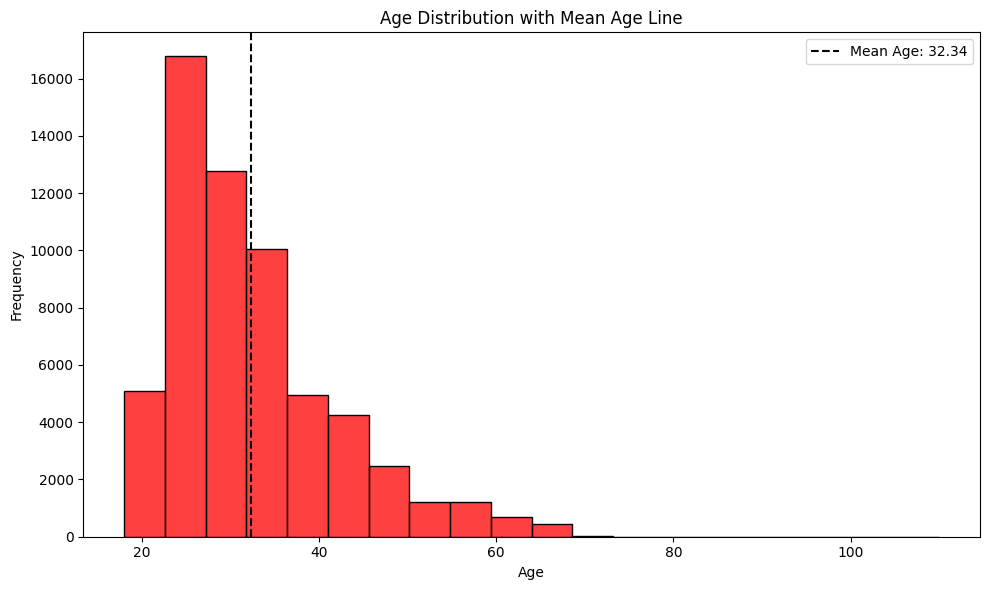

In [42]:
mean_age = data['age'].mean()
print("\nMean Age is:\n", mean_age.round(2))
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=False, color='red')
plt.axvline(mean_age, color='black', linestyle='--', label=f'Mean Age: {mean_age:.2f}')
plt.title("Age Distribution with Mean Age Line")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

*Conclusion: The mean age is 32.4 and most users are 25 years old.*

**Question 1.2: How does the age distribution differ by gender? Are there age groups where one gender is more prevalent?**

/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/1387529814.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution_by_gender = data.groupby(['gender', 'age_group'])['age_group'].value_counts().unstack(level=0, fill_value=0)


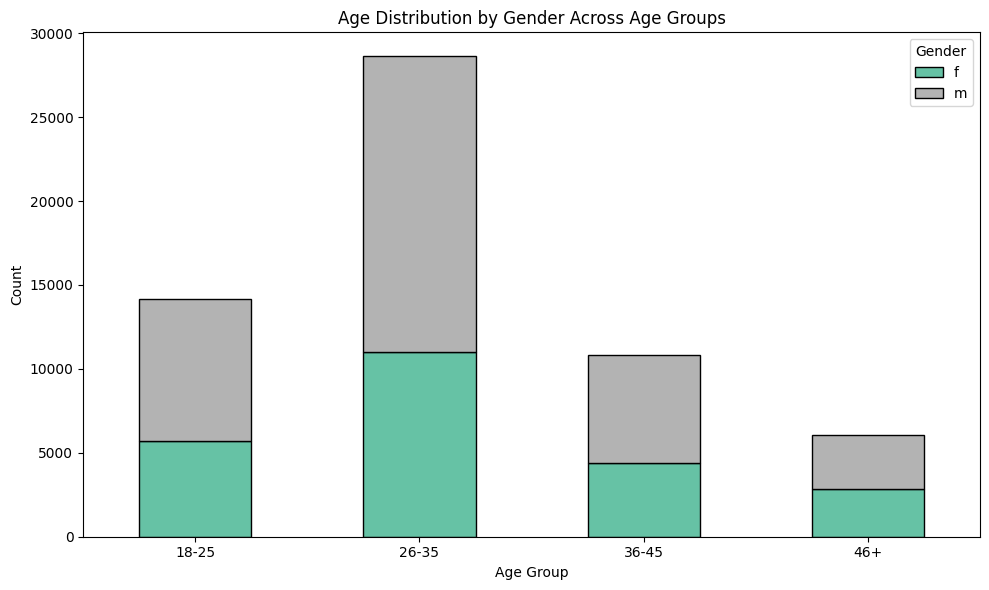

In [45]:
age_distribution_by_gender = data.groupby(['gender', 'age_group'])['age_group'].value_counts().unstack(level=0, fill_value=0)
age_distribution_by_gender.plot(kind='bar', figsize=(10, 6), stacked=True, colormap='Set2', edgecolor='black')
plt.title('Age Distribution by Gender Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

*Males are prevalent in all age groups. In the age group 26-35 females are more prevalant than others.*

## 2. Income and Age

Visualizing the relationship between income and age helps uncover patterns in reported income levels across age groups, which could inform user segmentation strategies.

**Question 2.1: Use a scatterplot to visualize the relationship between income and age, with a trend line indicating overall patterns. Are older users more likely to report higher incomes?**

/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/2516108257.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=filtered_data, x='age', y='income', palette='Set5', alpha=0.8,)


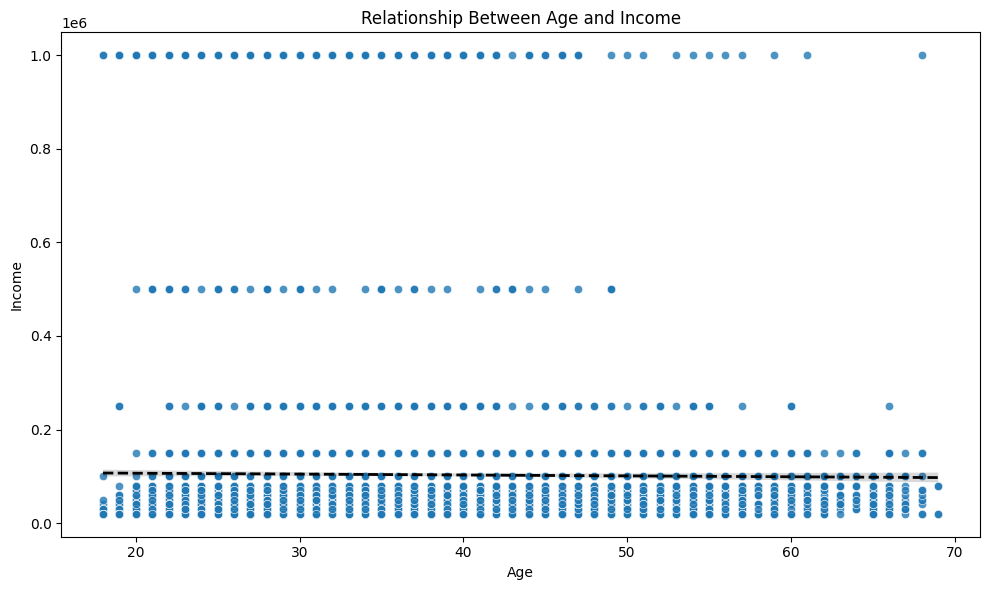

In [46]:
filtered_data = data[data['income'] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='age', y='income', palette='Set5', alpha=0.8,)
sns.regplot(data=filtered_data, x='age',y='income', scatter=False, color='black', line_kws={'linewidth': 2, 'linestyle': 'dashed'},)
plt.title('Relationship Between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

*Conclusion: Most users are low and medium income groups*

**Question 2.2: Create boxplots of income grouped by age_group. Which age group reports the highest median income?**

Income by Age Group:
 age_group
18-25    20000.0
26-35    50000.0
36-45    80000.0
46+      80000.0
Name: income, dtype: float64


/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/3092932247.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_by_age_group = filtered_data.groupby('age_group')['income'].median()
/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/3092932247.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='age_group', y='income', palette='Set2', showfliers = False)


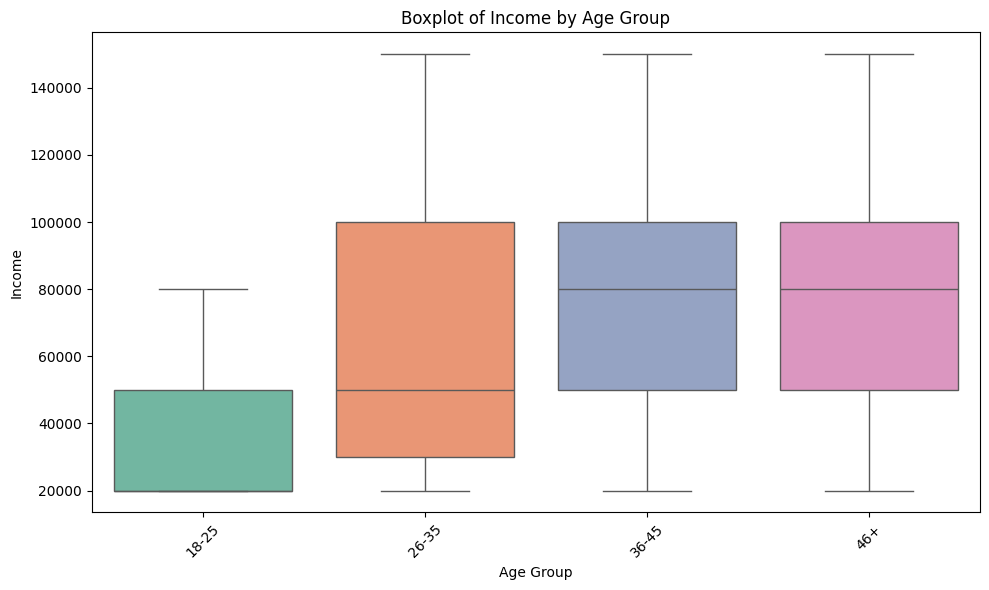

In [49]:
filtered_data = data[data['income'] > 0]
income_by_age_group = filtered_data.groupby('age_group')['income'].median()
print("Income by Age Group:\n", income_by_age_group)
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='age_group', y='income', palette='Set2', showfliers = False)
plt.title('Boxplot of Income by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Conclusion: Age group 36-45 and 46+ have highest median income possibly due to more experience being employed.*

**Question 2.3: Analyze income levels within gender and status categories. For example, are single men more likely to report higher incomes than single women?**

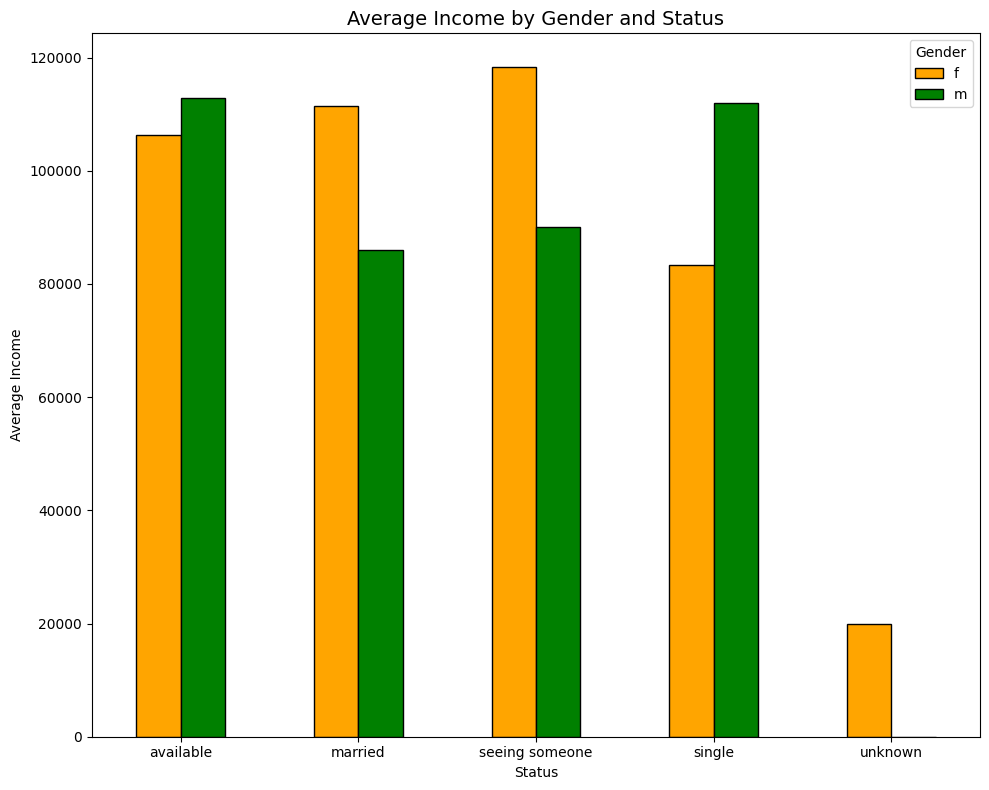

In [52]:
filtered_data = data[data['income'] > 0]
income_by_gender_status = filtered_data.groupby(['gender', 'status'])['income'].mean().reset_index()
pivot_data = income_by_gender_status.pivot(index='status', columns='gender', values='income')
pivot_data.plot(kind='bar', figsize=(10, 8), color=['orange', 'green'], edgecolor='black')
plt.title('Average Income by Gender and Status', fontsize=14)
plt.ylabel('Average Income')
plt.xlabel('Status')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

*Conclusion: Male with status as 'single' and 'available' reports highest average income, wheareas females with status 'seeing someone' reports highest average income.*

## 3. Pets and Preferences

Pets are often a key lifestyle preference and compatibility factor. Analyzing how pets preferences distribute across demographics can provide insights for filters or recommendations.

**Question 3.1: Create a bar chart showing the distribution of pets categories (e.g., likes dogs, likes cats). Which preferences are most common?**

Pets Distribution:
 pets
likes dogs and likes cats          14814
likes dogs                          7224
likes dogs and has cats             4313
has dogs                            4134
has dogs and likes cats             2333
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1406
likes cats                          1063
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: count, dtype: int64


/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/4210491480.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = pets_distribution.index, y = pets_distribution.values, palette='Set2')


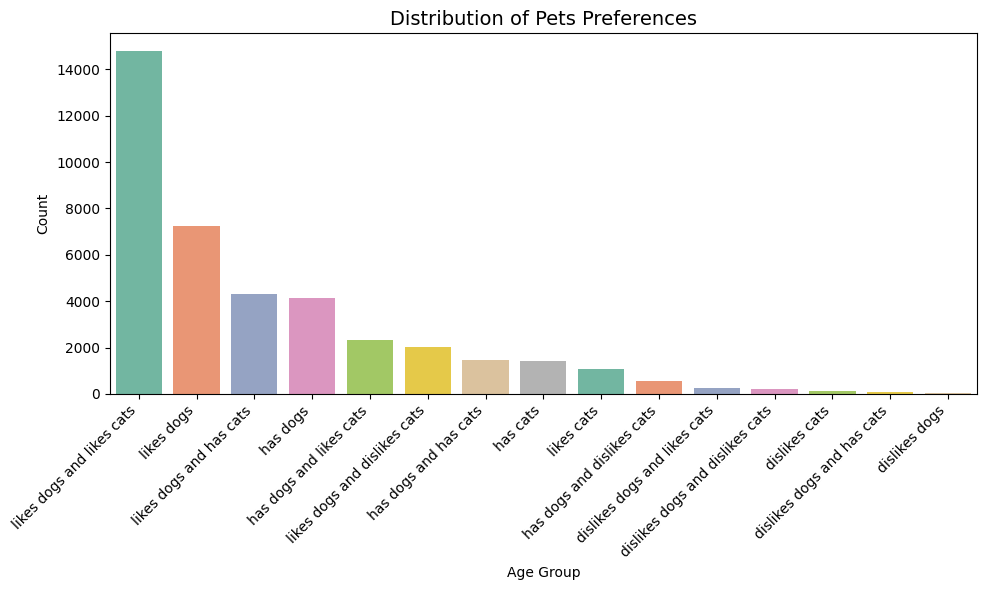

In [53]:
pets_distribution = data['pets'].value_counts()
print("Pets Distribution:\n", pets_distribution) 
plt.figure(figsize=(10, 6))
sns.barplot(x = pets_distribution.index, y = pets_distribution.values, palette='Set2')
plt.title('Distribution of Pets Preferences', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Conclusion: Most users like both dogs and cats.*

**Question 3.2: How do pets preferences vary across gender and age_group? Are younger users more likely to report liking pets compared to older users?**

age_group                        18-25  26-35  36-45   46+
pets                                                      
dislikes cats                       20     67     23    11
dislikes dogs                       12     22      9     1
dislikes dogs and dislikes cats     50     89     36    20
dislikes dogs and has cats          25     31     17     7
dislikes dogs and likes cats        63    115     40    20
has cats                           214    575    331   281
has dogs                           935   1787    814   572
has dogs and dislikes cats         181    241     82    40
has dogs and has cats              491    452    246   263
has dogs and likes cats            709    939    385   274
likes cats                         236    516    191   114
likes dogs                        1457   3989   1246   518
likes dogs and dislikes cats       531   1087    268   135
likes dogs and has cats            801   1805   1067   621
likes dogs and likes cats         3525   7194   2619  14

/var/folders/1h/lg645lm96h1fxhj49cpj1c4h0000gn/T/ipykernel_80305/2302868662.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pets_preference_by_age_group = data.groupby(['age_group'])['pets'].value_counts().unstack(level=0, fill_value=0)


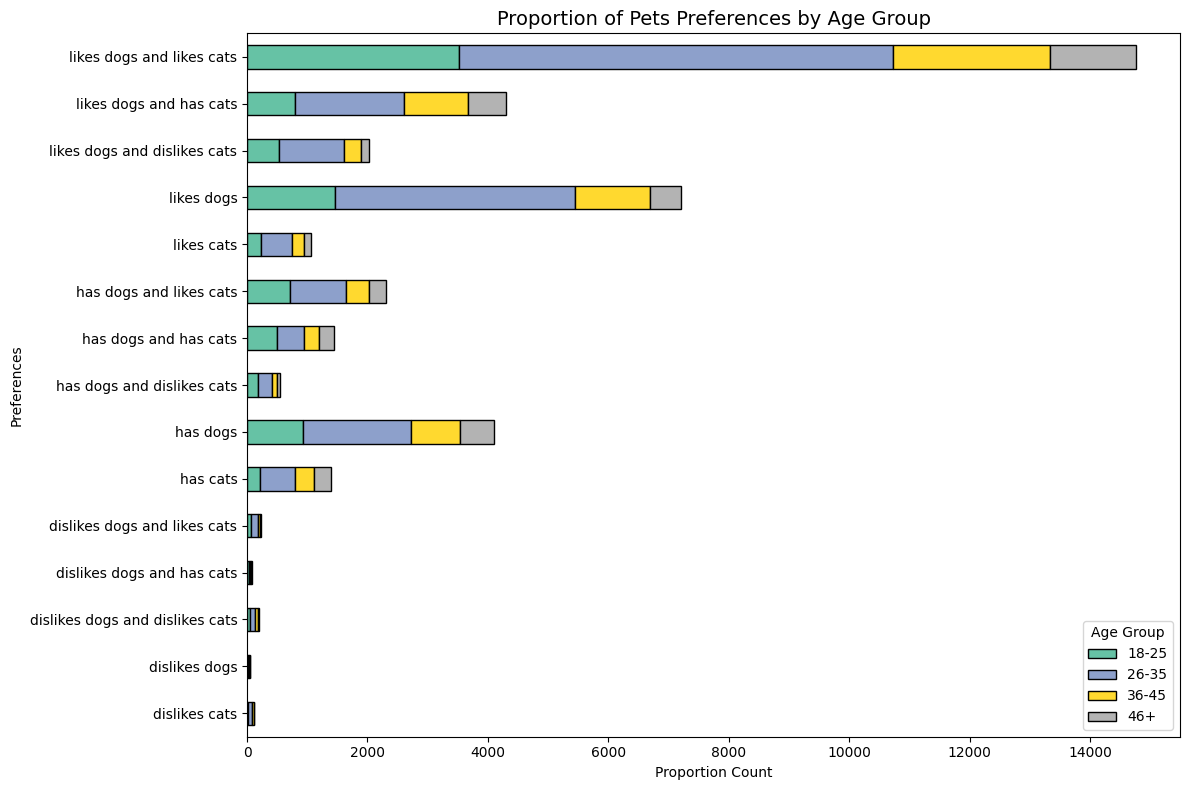

In [54]:
pets_preference_by_age_group = data.groupby(['age_group'])['pets'].value_counts().unstack(level=0, fill_value=0)
print(pets_preference_by_age_group)
pets_preference_by_age_group.plot(kind='barh', figsize=(12, 8), stacked=True, colormap='Set2', edgecolor='black')
plt.title('Proportion of Pets Preferences by Age Group', fontsize=14)
plt.xlabel('Proportion Count')
plt.ylabel('Preferences')
plt.legend(title='Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

*Conclusion:In all age groups maximum users fall in category of pet preference as 'like dogs and like cats'.*

gender                              f     m
pets                                       
dislikes cats                      58    64
dislikes dogs                      22    22
dislikes dogs and dislikes cats    95   101
dislikes dogs and has cats         32    49
dislikes dogs and likes cats       75   165
has cats                          795   611
has dogs                         1967  2167
has dogs and dislikes cats        314   238
has dogs and has cats             897   577
has dogs and likes cats          1150  1183
likes cats                        347   716
likes dogs                       2700  4524
likes dogs and dislikes cats      918  1111
likes dogs and has cats          2585  1728
likes dogs and likes cats        5264  9550


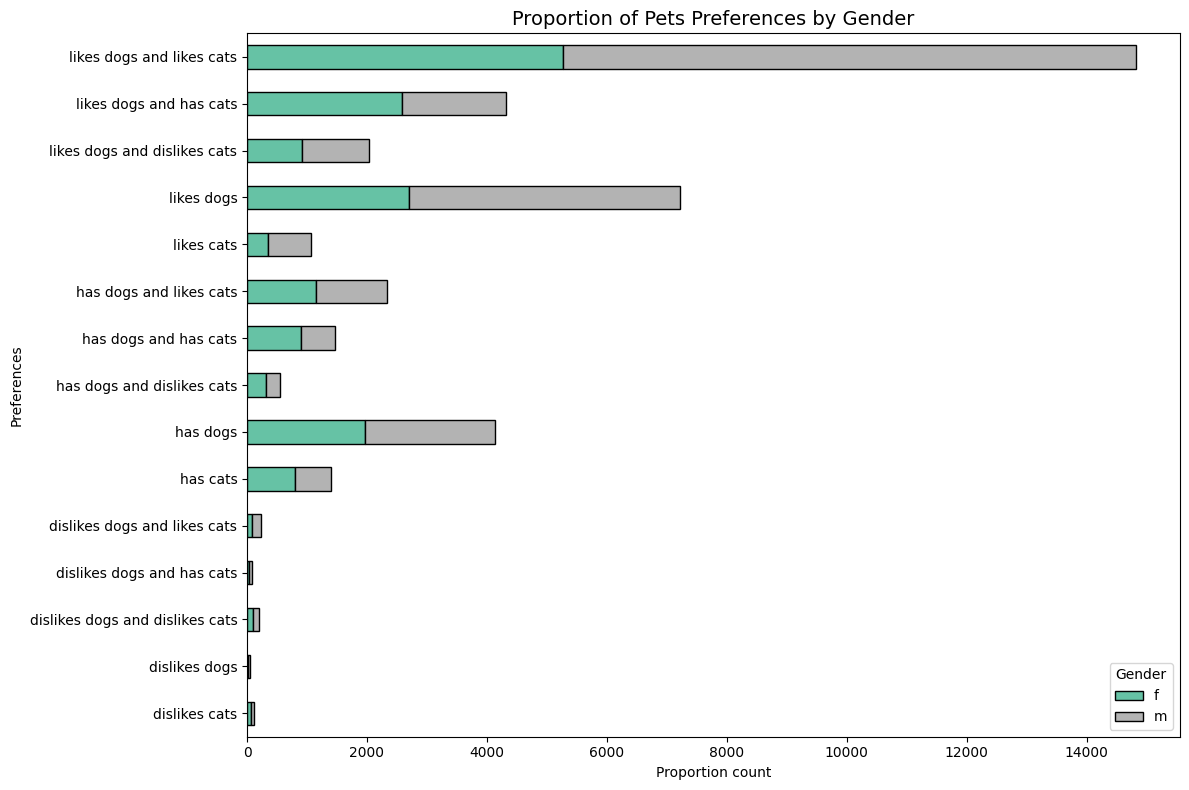

In [55]:
# calulating pet preference across gender and plottinf a horizontal bar graph
pets_preference_by_gender = data.groupby(['gender'])['pets'].value_counts().unstack(level=0, fill_value=0)
print(pets_preference_by_gender)
pets_preference_by_gender.plot(kind='barh', figsize=(12, 8), stacked=True, colormap='Set2', edgecolor='black')
plt.title('Proportion of Pets Preferences by Gender', fontsize=14)
plt.xlabel('Proportion count')
plt.ylabel('Preferences')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Conclusion:Both male and female users are highest for pet preference as 'like dogs and like cats'. Out of which male are more prevalent.

# 4. Signs and Personality
Users’ self-reported zodiac signs (sign) can offer insights into personality preferences or trends. While not scientifically grounded, analyzing this data helps explore fun and engaging patterns.

**Question 4.1: Create a pie chart showing the distribution of zodiac signs (sign) across the platform. Which signs are most and least represented? Is this the right chart? If not, replace with right chart.**

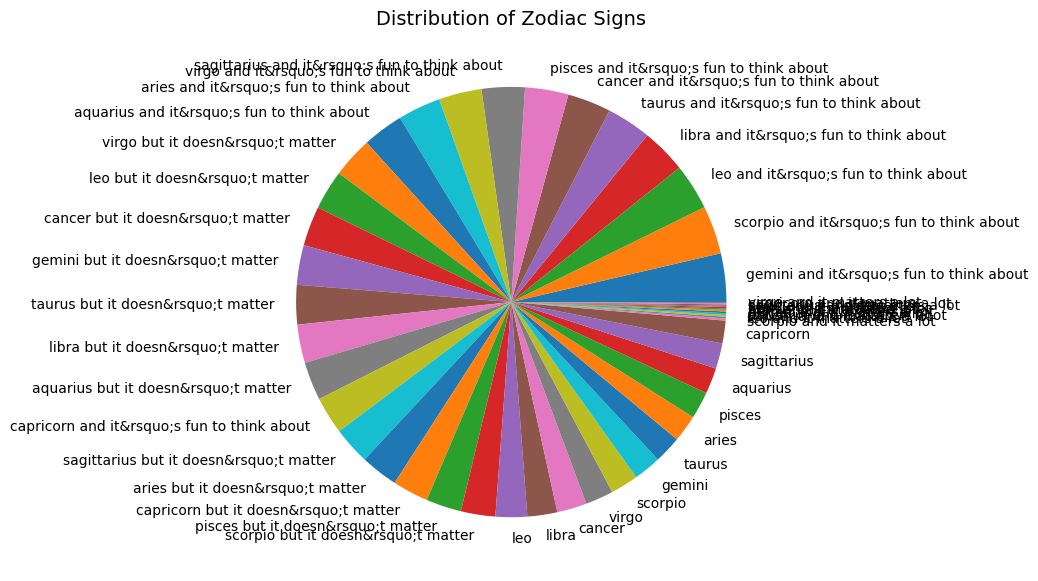

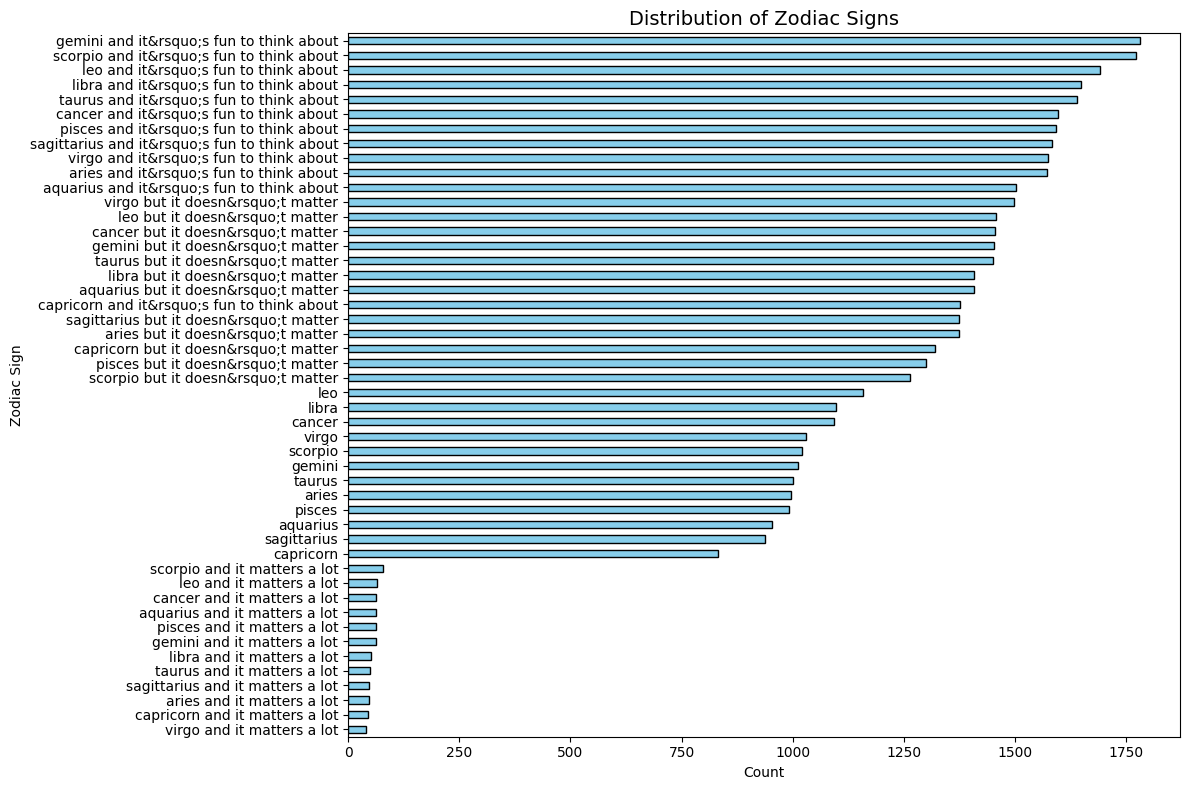

In [56]:
# calculating values of zodiac signs and plotting a pie chart.
sign_counts = data['sign'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(sign_counts.values, labels=sign_counts.index)
plt.title('Distribution of Zodiac Signs', fontsize=14)
plt.tight_layout()
plt.show()
# calculating values of zodiac signs and plotting a horizontal bar graph
sign_counts = data['sign'].value_counts().sort_values(ascending = True)
sign_counts.plot(kind='barh', figsize=(12, 8), color='skyblue', edgecolor='black')
plt.title('Distribution of Zodiac Signs', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Zodiac Sign')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

*Conclusion:Maximum number of users falls in sign category of 'gemini and its fun to think about' followed by 'scorpio and its to think about'.*

**Question 4.2: How does sign vary across gender and status? Are there noticeable patterns or imbalances?**

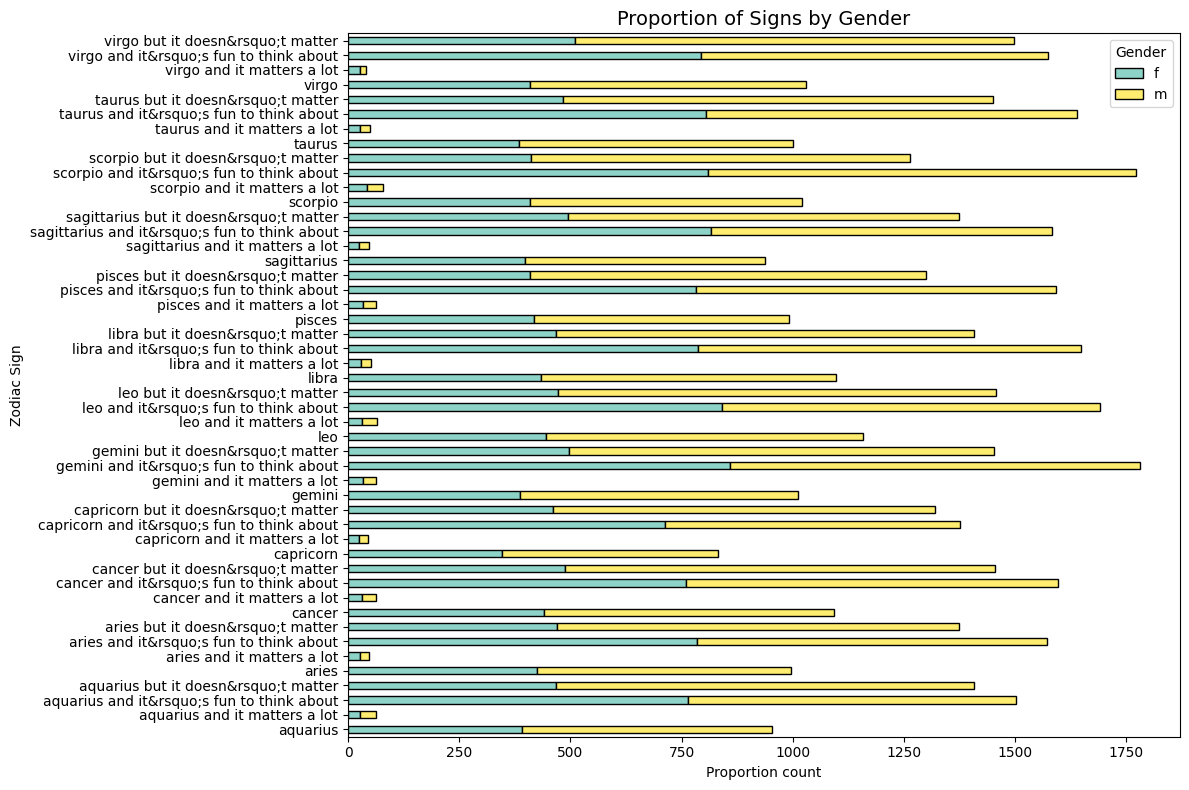

In [57]:
sign_count_by_gender = data.groupby(['gender'])['sign'].value_counts().unstack(level=0, fill_value=0)
sign_count_by_gender.plot(kind='barh', figsize=(12, 8), stacked=True, colormap='Set3', edgecolor='black')
plt.title('Proportion of Signs by Gender', fontsize=14)
plt.xlabel('Proportion count')
plt.ylabel('Zodiac Sign')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Maximum number of male and female users falls in sign category of 'gemini and its fun to think about' followed by 'scorpio and its to think about

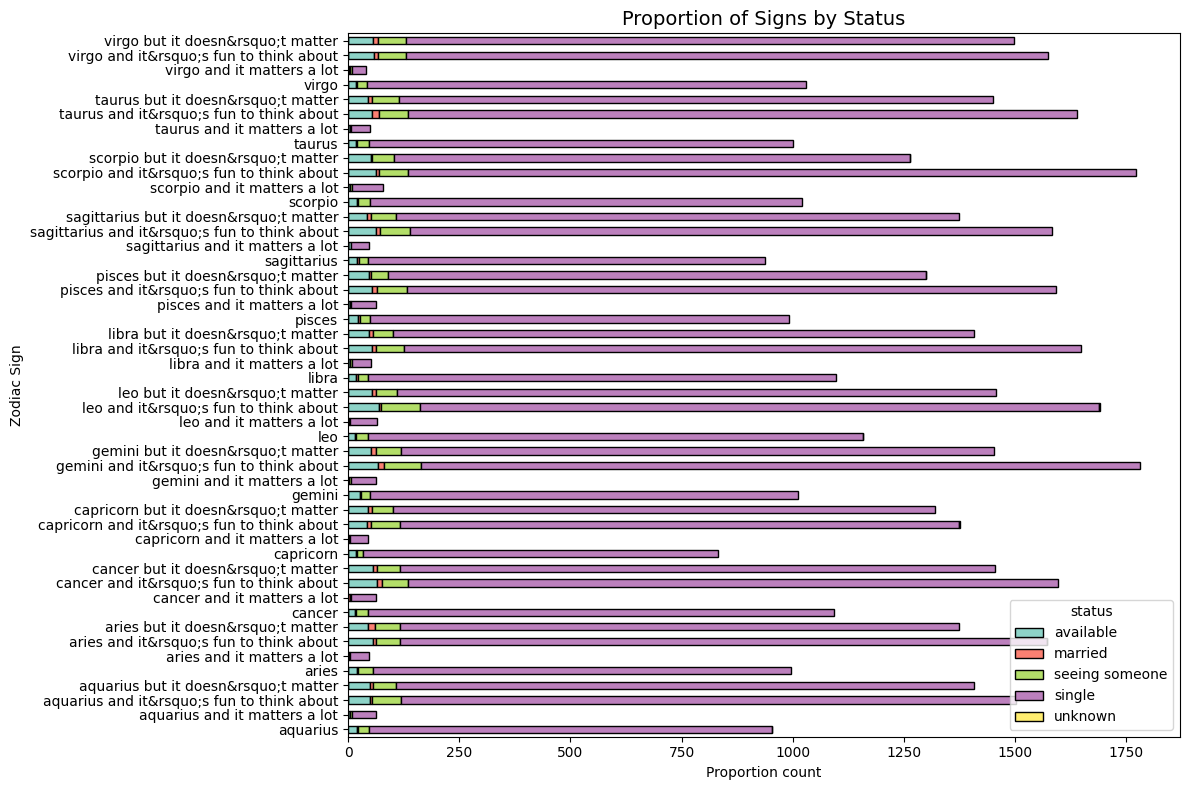

In [58]:
# calculating zodiac sign counts by status and plotting stacked horizontal bar graph
sign_count_by_status = data.groupby(['status'])['sign'].value_counts().unstack(level=0, fill_value=0)
sign_count_by_status.plot(kind='barh', figsize=(12, 8), stacked=True, colormap='Set3', edgecolor='black')
plt.title('Proportion of Signs by Status', fontsize=14)
plt.xlabel('Proportion count')
plt.ylabel('Zodiac Sign')
plt.legend(title='status')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Maximum number of users with different status falls in zodiac sign category of 'gemini and its fun to think about' followed by 'scorpio and its to think about'.

# Summary
1. The platform is most popular among young adults aged 18–35, with the 26–35 segment forming the largest group.
2. Male users make up a higher share of the user base than females, and males dominate every age group, especially 26–35.
3. Income distribution shows that most users fall into the 0–20k and 20k–50k brackets, while the highest average income is observed in the 26–35 age group.
4. Body type trends show that users identifying as athletic or fit not only form the majority but also exhibit higher average heights compared to other groups.
5. Diet preferences lean heavily toward flexible categories such as “mostly anything” and “anything,” while vegan and vegetarian users constitute a small minority. Drinking behavior also reflects that users with flexible diets tend to drink socially more often than restrictive diet groups.
6. Geographically, San Francisco, Oakland, and Berkeley host the largest user populations, with California leading all states by a significant margin.
7. In terms of lifestyle preferences, most users indicate liking both dogs and cats, with dog-friendly preferences being notably common.
8. Profile completeness shows a gender gap, with male users having more incomplete profiles on average. Additionally, both men (93.16%) and women (92.54%) predominantly identify as single, highlighting a large pool of active singles on the platform.
9. Income behavior shows a clear gender divide: males have higher average incomes in every age group, with peak earnings occurring in the 26–35 range. A very small segment of high-income users exhibits significantly elevated average earnings, presenting a premium monetization opportunity.

# Recomendations

1. Prioritize the 18–35 Age Group
As the largest demographic, targeted subscription offers, gamified features, and engagement campaigns can help retain this core audience—especially the highly active 26–35 segment.
2. Strengthen Male User Engagement
With males forming the majority and showing lower profile completeness, implement reminders, badges, and incentives encouraging them to complete profiles for improved matching.
3.	Offer Affordable, Tiered Subscriptions
Since most users fall into the 0–50k income bracket, budget-friendly or flexible subscription plans can increase conversion rates.
4.	Leverage Single User Dominance
Since over 90% of users identify as single, enhance matchmaking tools, conversation prompts, and singles-focused events to boost engagement.
5.	Improve Matchmaking for Diet Preferences
Vegan and vegetarian users form a small minority. Custom algorithms should help them find compatible matches without limiting options.
Larger diet groups (“mostly anything”) can be matched broadly to improve overall match success.
6.	Focus on Key Cities & States
Concentrate marketing and regional engagement efforts on high-density areas such as San Francisco, Oakland, Berkeley, and states like California, New York, and Illinois.
7.	Introduce Fitness & Lifestyle-Oriented Features
Since athletic and fit users dominate and show higher average heights, offer fitness communities, sports events, or profile badges tied to activity levels.
8.	Target High-Income Users with Premium Plans
The small but lucrative high-income group (avg ∼185k) is ideal for exclusive features, premium experiences, and top-tier subscriptions.
9.	Address Gender Income Differences Thoughtfully
Since males consistently show higher income than females across all age groups, tailor professional networking features or women-focused confidence campaigns to improve retention and spending.
10.	Enhance User Experience for 30+ Demographic
Offer serious relationship features, curated events, or maturity-focused communities to attract users aged 30+ and 46+ who have unique lifestyle and income patterns.
11.	Pet-Friendly Feature Expansion
Given the huge number of dog and cat lovers, integrate pet-related badges, pet-friendly meetups, and compatibility filters to enhance engagement.
12.	Highlight Height & Body Type Compatibility
Since noticeable height differences exist across body types (e.g., athletic vs. curvy), matchmaking models can incorporate body type preferences for more satisfying matches.
13.	Location-Based Personalization
Provide city-based event suggestions, community groups, or location-specific recommendations to strengthen engagement in heavily populated regions.
14.	Improve Recommendations for Young Adults (Age 25)
The highest engagement occurs at age 25. Tailored features such as meetups, relaxed dating options, or personalized suggestions will resonate strongly.